---
title: LeNet
categories: deep-learning
date: 2020-10-23
---

本文将介绍[LeNet](https://www.jiqizhixin.com/graph/technologies/6c9baf12-1a32-4c53-8217-8c9f69bd011b)，并用pytorch和tensorflow同时实现，然后对模型做一些优化。

## LeNet介绍

LeNet5诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。LeNet5通过巧妙的设计，利用卷积、参数共享、池化等操作提取特征，避免了大量的计算成本，最后再使用全连接神经网络进行分类识别，这个网络也是最近大量神经网络架构的起点。其结果图如下：

![image-20201019113632136](images/image-20201019113632136.png)

## 模型实现

### pytorch实现

从上面结构图来看，不算输入层，LeNet共有7层，但有参数的只有5层，所以在pytorch中使用torch.nn定了这5层，而其它两层使用torch.nn.functional来定义。下面是模型代码。

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)


class TaskTime:
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))

    
def compute_loss_accuarcy(net, loader, criterion, use_cuda=False, max_load_times=0):
    num_correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            if max_load_times>0 and i>=max_load_times: break
            inputs, labels = data
            _, loss, correct = forward(net, inputs, labels, criterion, use_cuda) 
            total += labels.size(0)
            total_loss += loss*labels.size(0)
            num_correct += correct    

    return total_loss/total, num_correct/total

def forward(net, inputs, labels, criterion, use_cuda=False):   
    if use_cuda and  torch.cuda.is_available(): 
        net = net.cuda()
        criterion = criterion.cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
    outputs = net(inputs)
    loss = criterion(outputs, labels)   
    _, predicted = torch.max(outputs.data, 1)
    num_correct = (predicted == labels).sum().item()
    num_total = labels.size(0)     
    return outputs, loss, num_correct        
    
def train(net, criterion, optimizer, trainloader, validationloader, epochs=2, use_cuda=False):  
        
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []      
    
    for epoch in range(epochs):         
        train_loss = 0.0
        train_num_correct = 0
        train_total = 0                   
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data   
            # 正向传播
            _, loss, correct = forward(net, inputs, labels, criterion, use_cuda)  
            
            train_loss += loss.item()*labels.size(0)
            train_num_correct += correct
            train_total += labels.size(0)     
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                        
            if i % 50 == 49:        
                sys.stdout.write('\r[epoch %2d/%2d %5d] loss: %.3f, accuracy: %.3f' % 
                                  (epoch + 1, epochs, i+1, train_loss/train_total, train_num_correct/train_total))                
                train_loss = 0.0
                train_num_correct = 0
                train_total = 0                   
                                                                                
        train_loss, train_accuracy = compute_loss_accuarcy(net, trainloader, criterion, 
                                                           use_cuda=True, max_load_times=50)   
        val_loss, val_accuracy = compute_loss_accuarcy(net, validationloader, criterion, 
                                                       use_cuda=True, max_load_times=50)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)         
        
        sys.stdout.write('\r[epoch %2d/%2d] loss: %.3f, accuracy: %.3f, val_loss: %.3f, val_accuracy: %.3f \n' %
                          (epoch + 1, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
         

    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

class LeNet(nn.Module):
    def __init__(self, in_dim=1, n_class=10):
        super(LeNet, self).__init__()    

        self.conv1 = nn.Conv2d(in_dim, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_class)        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

下面是数据加载的代码。采用的数据集是[CIFAR10](https://eipi10.cn/others/2020/10/22/dataset/#CIFAR10)。

2020-11-01 06:54:38,309: INFO: start 获取数据


Files already downloaded and verified
Files already downloaded and verified


2020-11-01 06:54:40,643: INFO: finish 获取数据 [elapsed time: 2.33 seconds]
2020-11-01 06:54:40,645: INFO: start 显示图片示例


torch.Size([32, 3, 32, 32])
  cat  ship  deer  frog plane  bird   dog  deer


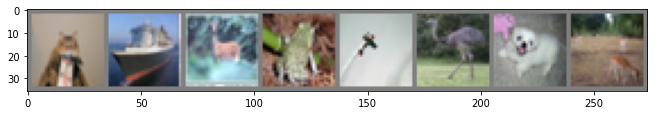

2020-11-01 06:54:41,407: INFO: finish 显示图片示例 [elapsed time: 0.76 seconds]


In [3]:
def torch_cifar10_extract_data():
    with TaskTime('获取数据', True):
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
        data_path = os.path.join(os.path.expanduser('~'), '.pytorch/datasets') 
        if not os.path.exists(data_path): os.makedirs(data_path)
        trainset = torchvision.datasets.CIFAR10(root=os.path.join(data_path, 'cifar10'), train=True,
                                                download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                                  shuffle=True, num_workers=2)

        testset = torchvision.datasets.CIFAR10(root=os.path.join(data_path, 'cifar10'), train=False,
                                               download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                                 shuffle=True, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')


    with TaskTime('显示图片示例', True):
        plt.rcParams['figure.figsize'] = (12.0, 1.5) 
        def imshow(img):
            img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            plt.show()

        # get some random training images
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        print(images.size())

        # show images
        print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
        imshow(torchvision.utils.make_grid(images[0:8]))

    return trainset, trainloader, testset, testloader

trainset, trainloader, testset, testloader = torch_cifar10_extract_data()

![image-20201023184915487](images/image-20201023184915487.png)

接下来是模型创建，模型训练，保存加载，以及模型评估的代码。

2020-11-01 07:03:25,323: INFO: start 创建模型


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


2020-11-01 07:03:25,827: INFO: finish 创建模型 [elapsed time: 0.50 seconds]
2020-11-01 07:03:25,829: INFO: start 显示参数


10
torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


2020-11-01 07:03:26,331: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:03:26,332: INFO: start 模型训练


[epoch  1/10] loss: 1.371, accuracy: 0.504, val_loss: 1.410, val_accuracy: 0.492 
[epoch  2/10] loss: 1.224, accuracy: 0.565, val_loss: 1.225, val_accuracy: 0.555 
[epoch  3/10] loss: 1.085, accuracy: 0.621, val_loss: 1.112, val_accuracy: 0.597 
[epoch  4/10] loss: 1.085, accuracy: 0.614, val_loss: 1.153, val_accuracy: 0.591 
[epoch  5/10] loss: 0.959, accuracy: 0.661, val_loss: 1.051, val_accuracy: 0.631 
[epoch  6/10] loss: 0.949, accuracy: 0.656, val_loss: 1.049, val_accuracy: 0.636 
[epoch  7/10] loss: 0.844, accuracy: 0.707, val_loss: 1.051, val_accuracy: 0.635 
[epoch  8/10] loss: 0.807, accuracy: 0.719, val_loss: 1.065, val_accuracy: 0.631 
[epoch  9/10] loss: 0.751, accuracy: 0.739, val_loss: 1.075, val_accuracy: 0.624 
[epoch 10/10] loss: 0.802, accuracy: 0.727, val_loss: 1.172, val_accuracy: 0.593 


2020-11-01 07:05:38,766: INFO: finish 模型训练 [elapsed time: 132.43 seconds]
2020-11-01 07:05:38,768: INFO: start 保存，加载模型
2020-11-01 07:05:39,283: INFO: finish 保存，加载模型 [elapsed time: 0.51 seconds]
2020-11-01 07:05:39,285: INFO: start 评估模型


Train Accuracy: 0.712, Test Accuracy: 0.617


2020-11-01 07:05:51,264: INFO: finish 评估模型 [elapsed time: 11.98 seconds]


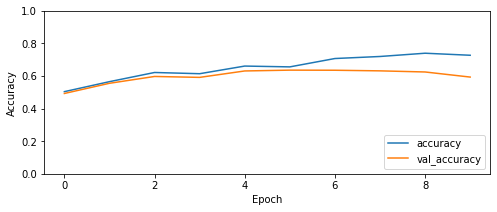

In [5]:
def torch_train_evaluate(net, epochs=10, save_model=False):                   
    with TaskTime('显示参数', True):
         # 由于存在bias，所以每一层都有两个参数张量，共有10个参数张量。
        params = list(net.parameters())
        print(len(params))
        for param in params:
            print(param.size())  

    with TaskTime('模型训练', True):
        criterion = nn.CrossEntropyLoss()
        # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)      # Adam优化的速度比SGD明显要快
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        _, train_accuracy_list, _, val_accuracy_list = train(
            net, criterion, optimizer, trainloader, testloader, epochs=epochs, use_cuda=True)

    if save_model:  
        with TaskTime('保存，加载模型', True):
            model_root_path = os.path.join(os.path.expanduser('~'), '.pytorch/model') 
            if not os.path.exists(model_root_path): os.makedirs(model_root_path)
            model_path = os.path.join(model_root_path, 'torch_lenet.pth')
            torch.save(net.state_dict(), model_path) 
            net = LeNet(in_dim=3, n_class=10)
            net.load_state_dict(torch.load(model_path))     

    with TaskTime('评估模型', True):
        plt.figure(figsize=(8, 3))
        plt.plot(train_accuracy_list, label='accuracy')
        plt.plot(val_accuracy_list, label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')          
        
        _, train_accuracy = compute_loss_accuarcy(net, trainloader, criterion, use_cuda=True)   
        _, test_accuracy = compute_loss_accuarcy(net, testloader, criterion, use_cuda=True)
        print('Train Accuracy: {:0.3f}, Test Accuracy: {:0.3f}'.format(train_accuracy, test_accuracy)) 
        
with TaskTime('创建模型', True):      
    net = LeNet(in_dim=3, n_class=10)
    print(net)

torch_train_evaluate(net, save_model=True, epochs=10)

准确率似乎不太好，只有60%多，且存在一定过拟合。

### tensorflow实现

首先是模型代码。

In [1]:
import logging
import os
import tensorflow as tf
import time
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

# 设置GPU内存使用上限
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

def lenet(in_dim=1, n_class=10):
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, in_dim)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(n_class))    
    return model

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


然后加载数据。

2020-11-01 07:06:40,625: INFO: start 获取数据


(50000, 32, 32, 3) (50000, 1) (50000, 32, 32, 3) (10000, 1)
<class 'numpy.ndarray'> <class 'tuple'>


2020-11-01 07:06:43,427: INFO: finish 获取数据 [elapsed time: 2.80 seconds]
2020-11-01 07:06:43,428: INFO: start 显示图片示例


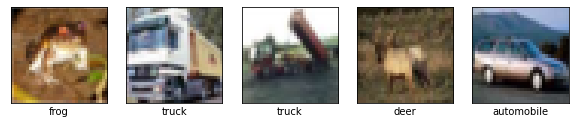

2020-11-01 07:06:44,220: INFO: finish 显示图片示例 [elapsed time: 0.79 seconds]


In [7]:
def tf_cifar10_extract_data():
    with TaskTime('获取数据', True):
        # 默认的保存路径是~/.keras/datasets/
        (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

        # Normalize pixel values to be between 0 and 1
        train_images, test_images = train_images / 255.0, test_images / 255.0

        print(train_images.shape, train_labels.shape, train_images.shape, test_labels.shape)
        print(type(train_images), type(train_labels.shape))

    with TaskTime('显示图片示例', True):
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

        plt.figure(figsize=(10,2))
        for i in range(5):
            plt.subplot(1,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(train_images[i])
            # The CIFAR labels happen to be arrays, 
            # which is why you need the extra index
            plt.xlabel(class_names[train_labels[i][0]])
        plt.show()
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = tf_cifar10_extract_data()

![image-20201023190145097](images/image-20201023190145097.png)

接下来是模型创建，模型训练，保存加载，以及模型评估的代码。

2020-11-01 07:07:23,868: INFO: start 创建模型
2020-11-01 07:07:25,059: INFO: finish 创建模型 [elapsed time: 1.19 seconds]
2020-11-01 07:07:25,062: INFO: start 显示参数


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

2020-11-01 07:07:25,568: INFO: finish 显示参数 [elapsed time: 0.51 seconds]
2020-11-01 07:07:25,569: INFO: start 模型训练


Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6379 - accuracy: 0.3977 - val_loss: 1.4798 - val_accuracy: 0.4577
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3583 - accuracy: 0.5092 - val_loss: 1.2882 - val_accuracy: 0.5307
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2402 - accuracy: 0.5568 - val_loss: 1.2094 - val_accuracy: 0.5717
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1613 - accuracy: 0.5853 - val_loss: 1.2051 - val_accuracy: 0.5754
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1020 - accuracy: 0.6083 - val_loss: 1.1871 - val_accuracy: 0.5834
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0559 - accuracy: 0.6265 - val_loss: 1.1016 - val_accuracy: 0.6105
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0150 - accuracy: 0.6412 - val_loss: 1.1016 - val_accuracy:

2020-11-01 07:08:23,346: INFO: finish 模型训练 [elapsed time: 57.78 seconds]
2020-11-01 07:08:23,348: INFO: start 保存，加载模型
2020-11-01 07:08:24,002: INFO: finish 保存，加载模型 [elapsed time: 0.65 seconds]
2020-11-01 07:08:24,003: INFO: start 评估模型


1563/1563 - 3s - loss: 0.8748 - accuracy: 0.6889
313/313 - 1s - loss: 1.1104 - accuracy: 0.6159
Train Accuracy: 0.689, Test Accuracy: 0.616


2020-11-01 07:08:30,020: INFO: finish 评估模型 [elapsed time: 6.02 seconds]


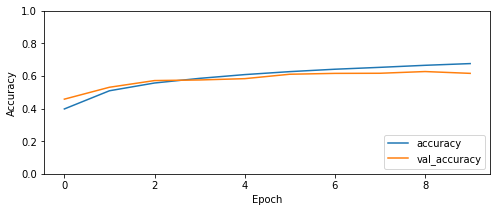

In [8]:
def tf_train_evaluate(model, epochs=10, save_model=False, callbacks=None):   
    with TaskTime('显示参数', True):
        model.summary()

    with TaskTime('模型训练', True):    
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=32,
                            callbacks=callbacks, validation_data=(test_images, test_labels))

    if save_model:
        with TaskTime('保存，加载模型', True): 
            model_root_path = os.path.join(os.path.expanduser('~'), '.keras/model') 
            if not os.path.exists(model_root_path): os.makedirs(model_root_path)
            model_path = os.path.join(model_root_path, 'tf_lenet.h5')
            model.save(model_path) 
            model = tf.keras.models.load_model(model_path)  

    with TaskTime('评估模型', True): 
        plt.figure(figsize=(8, 3))
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')

        train_loss, train_acc = model.evaluate(train_images,  train_labels, verbose=2)
        test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
        print('Train Accuracy: {:0.3f}, Test Accuracy: {:0.3f}'.format(train_acc, test_acc)) 
    
with TaskTime('创建模型', True): 
    model = lenet(in_dim=3, n_class=10)

tf_train_evaluate(model, save_model=True)

![image-20201023190919046](images/image-20201023190919046.png)

![image-20201023191128872](images/image-20201023191128872.png)

accuracy，和pytorch非常接近，也是60%多，但同样10次迭代，只需要一半的时间（55秒多），可能原因是上面pytorch中training的代码是自己写的，而tensorflow中都是调用tf原生的函数。

## 模型优化

上节中，采用pytorch和tensoflow实现了LeNet，但accuracy不是很高，只有60%多，下面对模型做一些修改，看看性能如何。

### pytorch优化

增加了一层卷积，并大大增加了卷积的深度，同时减少了一层全连接层（或许可以减少一些过拟合）。

In [9]:
class LeNet1(nn.Module):
    def __init__(self, in_dim=1, n_class=10):
        super(LeNet1, self).__init__()    

        self.conv1 = nn.Conv2d(in_dim, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  
        self.fc2 = nn.Linear(64, n_class)        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), stride=2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

看看模型的效果。

2020-11-01 07:18:58,353: INFO: start 创建模型


LeNet1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


2020-11-01 07:18:58,860: INFO: finish 创建模型 [elapsed time: 0.51 seconds]
2020-11-01 07:18:58,861: INFO: start 显示参数


10
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64, 1024])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


2020-11-01 07:18:59,365: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:18:59,366: INFO: start 模型训练


[epoch  1/10] loss: 1.188, accuracy: 0.578, val_loss: 1.243, val_accuracy: 0.552 
[epoch  2/10] loss: 1.062, accuracy: 0.631, val_loss: 1.088, val_accuracy: 0.615 
[epoch  3/10] loss: 0.852, accuracy: 0.697, val_loss: 0.961, val_accuracy: 0.661 
[epoch  4/10] loss: 0.749, accuracy: 0.743, val_loss: 0.859, val_accuracy: 0.698 
[epoch  5/10] loss: 0.670, accuracy: 0.767, val_loss: 0.915, val_accuracy: 0.686 
[epoch  6/10] loss: 0.642, accuracy: 0.781, val_loss: 0.860, val_accuracy: 0.708 
[epoch  7/10] loss: 0.601, accuracy: 0.787, val_loss: 0.844, val_accuracy: 0.721 
[epoch  8/10] loss: 0.561, accuracy: 0.806, val_loss: 0.847, val_accuracy: 0.714 
[epoch  9/10] loss: 0.514, accuracy: 0.828, val_loss: 0.788, val_accuracy: 0.739 
[epoch 10/10] loss: 0.431, accuracy: 0.846, val_loss: 0.852, val_accuracy: 0.729 


2020-11-01 07:21:20,862: INFO: finish 模型训练 [elapsed time: 141.50 seconds]
2020-11-01 07:21:20,863: INFO: start 评估模型


Train Accuracy: 0.839, Test Accuracy: 0.731


2020-11-01 07:21:33,201: INFO: finish 评估模型 [elapsed time: 12.34 seconds]


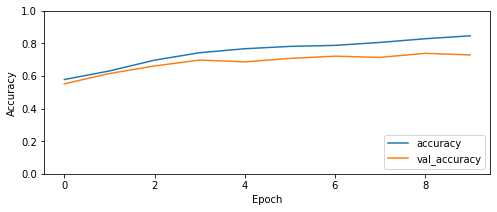

In [10]:
with TaskTime('创建模型', True): 
    net = LeNet1(in_dim=3, n_class=10)
    print(net)

torch_train_evaluate(net)

![image-20201023191256464](images/image-20201023191256464.png)

![image-20201023230118589](images/image-20201023230118589.png)

test accuracy提高到了72%，效果提升明显。

### tensorflow优化

采用相同的方式，同样更新模型。

In [11]:
def lenet1(in_dim=1, n_class=10):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, in_dim)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(n_class))    
    return model

同样看看模型的效果。

2020-11-01 07:22:57,199: INFO: start 创建模型
2020-11-01 07:22:57,798: INFO: finish 创建模型 [elapsed time: 0.60 seconds]
2020-11-01 07:22:57,800: INFO: start 显示参数


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

2020-11-01 07:22:58,304: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:22:58,305: INFO: start 模型训练


Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5006 - accuracy: 0.4519 - val_loss: 1.2123 - val_accuracy: 0.5664
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1586 - accuracy: 0.5882 - val_loss: 1.0448 - val_accuracy: 0.6290
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0139 - accuracy: 0.6420 - val_loss: 1.0879 - val_accuracy: 0.6172
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9236 - accuracy: 0.6741 - val_loss: 0.9539 - val_accuracy: 0.6640
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8586 - accuracy: 0.6969 - val_loss: 0.9043 - val_accuracy: 0.6808
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7953 - accuracy: 0.7220 - val_loss: 0.8994 - val_accuracy: 0.6879
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7517 - accuracy: 0.7354 - val_loss: 0.8616 - val_accuracy:

2020-11-01 07:23:58,285: INFO: finish 模型训练 [elapsed time: 59.98 seconds]
2020-11-01 07:23:58,286: INFO: start 评估模型


1563/1563 - 3s - loss: 0.5544 - accuracy: 0.8029
313/313 - 1s - loss: 0.8533 - accuracy: 0.7178
Train Accuracy: 0.803, Test Accuracy: 0.718


2020-11-01 07:24:03,862: INFO: finish 评估模型 [elapsed time: 5.58 seconds]


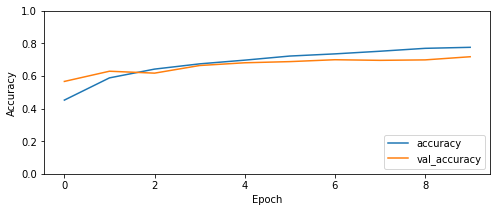

In [12]:
with TaskTime('创建模型', True): 
    model = lenet1(in_dim=3, n_class=10)

tf_train_evaluate(model)

In [2]:
model =lenet()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [12]:
!pip install pydot pydotplus 
!apt-get install -y graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation libann0
  libcairo2 libcdt5 libcgraph6 libdatrie1 libfontconfig1 libgd3 libgraphite2-3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libharfbuzz0b libice6 libjbig0
  liblab-gamut1 libltdl7 libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0
  libpathplan4 libpixman-1-0 libsm6 libthai-data libthai0 libtiff5 libwebp6
  libxaw7 libxcb-render0 libxcb-shm0 libxmu6 libxpm4 libxrender1 libxt6
  x11-common
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation graphviz
  libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libfontconfig1 libgd3
  libgraphite2-3 libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libharfbuzz0b
  libice6 libjbig0 liblab-gamut1 libltdl7 libpango-1.0-0 libpango

Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../14-libxpm4_1%3a3.5.12-1_amd64.deb ...
Unpacking libxpm4:amd64 (1:3.5.12-1) ...
Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../15-libgd3_2.2.5-4ubuntu0.4_amd64.deb ...
Unpacking libgd3:amd64 (2.2.5-4ubuntu0.4) ...
Selecting previously unselected package libgts-0.7-5:amd64.
Preparing to unpack .../16-libgts-0.7-5_0.7.6+darcs121130-4_amd64.deb ...
Unpacking libgts-0.7-5:amd64 (0.7.6+darcs121130-4) ...
Selecting previously unselected package libpixman-1-0:amd64.
Preparing to unpack .../17-libpixman-1-0_0.34.0-2_amd64.deb ...
Unpacking libpixman-1-0:amd64 (0.34.0-2) ...
Selecting previously unselected package libxcb-render0:amd64.
Preparing to unpack .../18-libxcb-render0_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb-render0:amd64 (1.13-2~ubuntu18.04) ...
Selecting previously unselected package libxcb-shm0:amd64.
Preparing to unpack .../19-libxcb-shm0_1.13-2~ubuntu18.04_amd64.de

In [6]:
for weight in model.weights:
    print(weight.shape)

(5, 5, 1, 6)
(6,)
(5, 5, 6, 16)
(16,)
(400, 120)
(120,)
(120, 84)
(84,)
(84, 10)
(10,)


In [7]:
for layer in model.layers:
    print('-'*50)
    print(layer.input)
    print(layer.output)

--------------------------------------------------
Tensor("conv2d_input:0", shape=(None, 32, 32, 1), dtype=float32)
Tensor("conv2d/Relu:0", shape=(None, 28, 28, 6), dtype=float32)
--------------------------------------------------
Tensor("conv2d/Relu:0", shape=(None, 28, 28, 6), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(None, 14, 14, 6), dtype=float32)
--------------------------------------------------
Tensor("max_pooling2d/MaxPool:0", shape=(None, 14, 14, 6), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(None, 10, 10, 16), dtype=float32)
--------------------------------------------------
Tensor("conv2d_1/Relu:0", shape=(None, 10, 10, 16), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(None, 5, 5, 16), dtype=float32)
--------------------------------------------------
Tensor("max_pooling2d_1/MaxPool:0", shape=(None, 5, 5, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(None, 400), dtype=float32)
--------------------------------------------------
Tensor(

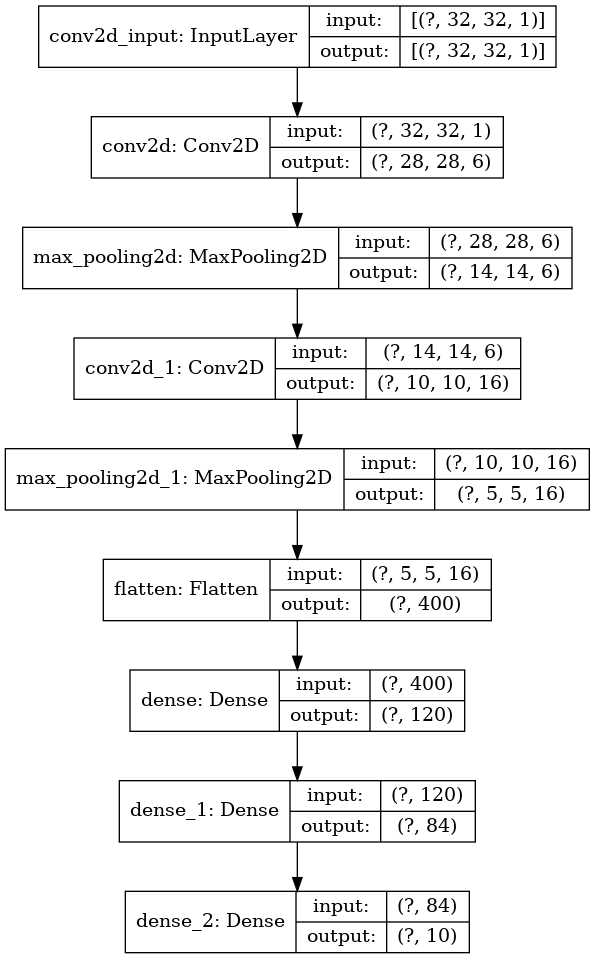

In [3]:
tf.keras.utils.plot_model(model, 'letnet.png', show_shapes=True)

![image-20201023231627664](images/image-20201023231627664.png)

![image-20201023231728031](images/image-20201023231728031.png)

test accuracy提高到了70%，效果提升也很明显。

## 参考

- [TF Tutorial - Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)
- [Torch Tutorial - TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## 历史

- 2020-10-23：初始版本
- 2020-10-30：tensorflow增加了tensorboard可视化显示， pytorch增加了曲线图。
- 2020-11-01：pytorch训练时，增加了validation accuaracy。